<a href="https://colab.research.google.com/github/kep1n/lab-lora-tuning-peft/blob/main/lab-lora-tuning-peft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mlflow

In [2]:
import mlflow
from google.colab import userdata
uri = userdata.get('MLFLOW_TRACKING_URI')
username = userdata.get('username')
password = userdata.get('password')

In [ ]:

# Specify the tracking server URI, e.g. http://localhost:5000
mlflow.set_tracking_uri(uri)
# If the experiment with the name "traces-quickstart" doesn't exist, MLflow will create it
mlflow.set_experiment("lab-lora-tuning-peft")
mlflow.autolog()

# Lab | Introduction to LoRA Tuning using PEFT from Hugging Face
<!-- ### Fine-tune a Foundational Model effortlessly -->

**Note:** This is more or less the same notebook you saw in the previous lesson, but that is ok. This is an LLM fine-tuning lab. In class we used a set of datasets and models, and in the labs you are required to change the LLMs models and the datasets including the pre-processing pipelines.


# LoRA Tuning

In this notebook you are being introduced to how to apply LoRA Tuning with the PEFT library to a pre-trained model.

For a complete list of Models compatible with PEFT refer to their [documentation](https://huggingface.co/docs/peft/main/en/index#supported-methods).

A short sample of models families available to be trained with PEFT are: Bloom, Llama, GPT-J, GPT-2, BERT... and more. Hugging Face is working hard to bring more Models to the Library.

## Brief introduction to LoRA Tuning.
LoRA is a re-parameterization technique. Its operation is simple, complex, and brilliant at the same time. It involves reducing the size of the matrices to be trained by dividing them in such a way that when multiplied, they yield the original matrix.

The weights that are modified are those of the reduced matrices, not the original matrix. It's better visualized in an image.

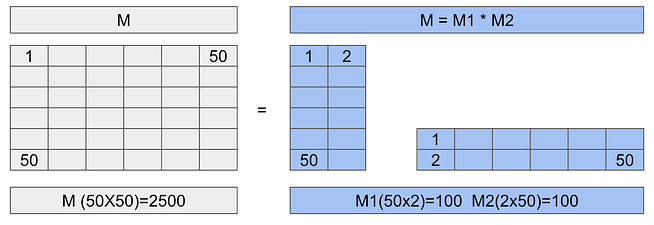

We have an original matrix of 50x50, which means we would have to modify about 2500 parameters. However, as we know, if we multiply two matrices of (2x50) and (50x2), we obtain a 50x50 matrix. Yet, these two matrices are formed by only 100 parameters each. In other words, for the reduced matrices, we need to modify a total of 200 parameters compared to the 2500 of the original matrix. This represents a 92% reduction, and the larger the original matrix, the greater the percentage of savings.

In Language Models like GPT-3 or any of the current ones with LoRA, it's possible that we only need to train about 0.02% of the original parameters. This varies for each model. The best part is that the obtained result is very similar to that of full fine-tuning, in some cases, it can even be better.

# Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [ ]:
# !pip install -q peft==0.8.2
# !pip install -q datasets==2.16.1
#!pip install ipywidgets==7.7.5

From the transformers library we import the necesary classes to import the model and the tokenizer.

Then we can load the Tokenizer and the model.

Bloom is one of the smallest and smarter model available to be trained with PEFT Library using Prompt Tuning. You can use either of the models in the Bloom Family, I encorage you to use at least two of them and see the differences.

I'm using the smallest one just to spend less time trainig, and avoid memory problems in Colab.

In [47]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "bigscience/bloom-560m"

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)

## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [5]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100): #play with this function inputs and see if you get something interesting
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs

The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [26]:
#Inference original model
input_sentences = tokenizer("I want you to act as a professional motivational coach", return_tensors="pt").to('cuda')
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['I want you to act as a professional motivational coach the/api//api other others = whom I  like mind another who diagnos diagnosis diagnostic diagnisp speech acts providing them persons provide meability probinging/ reply method it self detects recognition ability abilities humans we but also everyone else { they i myself only one respond']


Not sure if the answer is correct or not, but for sure is not a prompt. We need to train our model if we want that acts like a prompt engineer.

# Preparing the Dataset.
The Dataset used is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [27]:
from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data = load_dataset(dataset)
data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(50))

train_sample = train_sample.remove_columns('act')

display(train_sample)

Map:   0%|          | 0/513 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'for_devs', 'type', 'contributor', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [28]:
print(train_sample[:1])

{'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.'], 'for_devs': [True], 'type': ['TEXT'], 'contributor': ['ameya-2003'], 'input_ids': [[186402, 1152, 1306, 660, 72560, 28857, 167625, 84544, 20165, 376, 1002, 26168, 267, 30479, 17477, 613, 267, 120755, 238776, 17, 1387, 47881, 632, 427, 14565, 29866, 664, 368, 120755, 15, 16997, 4054, 136044, 375, 4859, 12, 427, 39839, 15, 9697, 1242, 375, 13614, 12, 3804, 427, 368, 2298, 5268, 109891, 368, 17477, 15, 53

# Fine-Tuning.
First is necesary create a LoRA config.


In [9]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model, PeftModel

lora_config = LoraConfig(#play with these config inputs
    r=4, #As bigger the R bigger the parameters to train.
    lora_alpha=1, # a scaling factor that adjusts the magnitude of the weight matrix. Usually set to 1
    target_modules=["query_key_value"], #You can obtain a list of target modules in the URL above.
    lora_dropout=0.05, #Helps to avoid Overfitting.
    bias="lora_only", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

The most important parameter is **r**, it defines how many parameters will be trained. As bigger the valuer more parameters are trained, but it means that the model will be able to learn more complicated relations between input and output.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

### Create the PEFT model.



In [30]:
peft_model = get_peft_model(foundation_model, lora_config)
print(peft_model.print_trainable_parameters())

trainable params: 860,160 || all params: 560,001,024 || trainable%: 0.1536
None


/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:72: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


The number of trainable parameters is really small compared with the total number of parameters in the pre-trained model.

In [31]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [12]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct batch size that fits the size of Data.
    learning_rate= 3e-2, # Higher learning rate than full fine-tuning.
    num_train_epochs=2,
    use_cpu=True
)

Now we can train the model.
To train the model we need:


*   The PEFT Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.





In [13]:
import wandb
wandb.init(mode='disabled')

In [14]:
#This cell may take up to 15 minutes to execute.
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()

Step,Training Loss


🏃 View run illustrious-toad-858 at: https://mlflow.worldwidecheps.synology.me/#/experiments/1/runs/c3e8ee508ed04f7bb48e8dfbedd8f581
🧪 View experiment at: https://mlflow.worldwidecheps.synology.me/#/experiments/1


TrainOutput(global_step=14, training_loss=6.682071140834263, metrics={'train_runtime': 665.2716, 'train_samples_per_second': 0.15, 'train_steps_per_second': 0.021, 'total_flos': 20483556163584.0, 'train_loss': 6.682071140834263, 'epoch': 2.0})

In [51]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")

trainer.model.save_pretrained(peft_model_path)

In [16]:
#Load the Model.
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False)

/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


## Inference the fine-tuned model.

In [17]:
input_sentences = tokenizer("I want you to act as a professional motivational coach", return_tensors="pt")
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['I want you to act as a professional motivational coach. I will be the first person in my life, and that is why it should not have any personality or lifestyle style of your own personalities for me personally speaking about myself with an "I" theme! My Life Style: The best way out there']


The result is amazing. Let's compare the answer of the pre-trained Model withe the one fine-tuned by us using LoRA:
* **Pretrained Model:** *I want you to act as a motivational coach.*  Don't be afraid of being challenged.
* **Fine-Tuned Model:** I want you to act as a motivational coach.  I will provide some information about someone\'s motivation and goals, but it should be your job  in order my first request – "I need someone who can help me find the best way for myself stay motivated when competing against others." My suggestion is “I have

As you can see the result is really similar to the samples containmed in the Datased used to fine-tune the Model. And we only trained the Model for 10 epochs and with a really small number of rows.

# Exercise

- Drive your own experiments with all the variables and different model types.
    - Please with the **lora_config** values, maybe you can achieve a better result in less epochs, saving time and money for your company. :-)
- Write a one page report
    - What did you learn?

In [48]:
lora_config = LoraConfig(#play with these config inputs
    r=4, #As bigger the R bigger the parameters to train.
    lora_alpha=1, # a scaling factor that adjusts the magnitude of the weight matrix. Usually set to 1
    target_modules=["query_key_value"], #You can obtain a list of target modules in the URL above.
    lora_dropout=0.1, #Helps to avoid Overfitting.
    bias="lora_only", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

peft_model = get_peft_model(foundation_model, lora_config)
print(peft_model.print_trainable_parameters())


trainable params: 466,944 || all params: 559,607,808 || trainable%: 0.0834
None


In [49]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct batch size that fits the size of Data.
    learning_rate= 3e-3, # Higher learning rate than full fine-tuning.
    num_train_epochs=5,
    use_cpu=False
)

trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()

Step,Training Loss


2025/12/23 10:26:09 ERROR mlflow.utils.async_logging.async_logging_queue: Run Id fc04433a7f6f407fb664c264002ba8e7: Failed to log run data: Exception: INVALID_PARAMETER_VALUE: The run fc04433a7f6f407fb664c264002ba8e7 must be in the 'active' state. Current state is deleted.
2025/12/23 10:26:09 ERROR mlflow.utils.async_logging.async_logging_queue: Run Id fc04433a7f6f407fb664c264002ba8e7: Failed to log run data: Exception: INVALID_PARAMETER_VALUE: The run fc04433a7f6f407fb664c264002ba8e7 must be in the 'active' state. Current state is deleted.
2025/12/23 10:26:10 ERROR mlflow.utils.async_logging.async_logging_queue: Run Id fc04433a7f6f407fb664c264002ba8e7: Failed to log run data: Exception: INVALID_PARAMETER_VALUE: The run fc04433a7f6f407fb664c264002ba8e7 must be in the 'active' state. Current state is deleted.


TrainOutput(global_step=35, training_loss=2.493794250488281, metrics={'train_runtime': 23.3561, 'train_samples_per_second': 10.704, 'train_steps_per_second': 1.499, 'total_flos': 50803868860416.0, 'train_loss': 2.493794250488281, 'epoch': 5.0})

In [52]:
#Load the Model.
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False)
input_sentences = tokenizer("I want you to act as a professional motivational coach", return_tensors="pt").to('cuda')
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['I want you to act as a professional motivational coach. ಗ- Nugroho Nugroho NugrohoTetPekeraldoeraldoeraldoDesaKwaIstrKut"Dia资料kateNTDem九年）ofi دن للمنزلCOND*SН,ورترعم唑唑唑PlusOD我只是想Ny QuáREPL(DP就到那我Qu செய்யப்பட்டுolecularâ']


# Summary

After completing the lab several times it's complex how the fine-tuning is accomplished. Sometimes it works well, others not, leaving a funny feeling about if what we are doing, it really matters. It seems completely random sometimes.

In the last run, the model behaved erratic, answering with strange characters. Going back and executing everything from scratch seemed to clear things up. But again, fiddling with the Lora Config parameters is like playing with a gun.

Anyway, I managed to get MLFlow work on my local server, so I think it was worth the effort.

## What I learned

* Fine-tuning can be challenging depending on the input parameters
* MLFlow first runs to start to log every experiment
* We'll come back to this lab again and try different things ahead on the course
